### Explore embeddings with umap

In this Notebook we shows how embeddings brings inside the topic, the source (the book) of the chunck.

Even if we map the embeddings onto a 2d space (with umap) we see clearly two clusters... non overlapping

We use HF embeddings

In [11]:
import umap
import numpy as np

from config_rag import BOOK_LIST, CHUNK_SIZE, CHUNK_OVERLAP, EMBED_HF_MODEL_NAME

from init_rag import post_process

# modified to load from Pdf
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.vectorstores import FAISS

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

### load pages and split in chunks

In [2]:
all_pages = []

# modified to load a list of pdf
BOOK1 = "./oracle-database-23c-new-features-guide.pdf"
BOOK2 = "./database-concepts.pdf"
BOOK3 = "./visualizing-data-and-building-reports-oracle-analytics-cloud.pdf"

BOOK_LIST = [BOOK1, BOOK2, BOOK3]

for book in BOOK_LIST:
    print(f"Loading book: {book}...")
    loader = PyPDFLoader(book)

    # loader split in pages
    pages = loader.load()
    print(f"Loaded {len(pages)} pages...")

    all_pages.extend(pages)

    print("PDF document loaded!")

# This split in chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP
)

splits = text_splitter.split_documents(all_pages)

print(f"We have splitted the pdf in {len(splits)} splits...")

Loading book: ./oracle-database-23c-new-features-guide.pdf...
Loaded 96 pages...
PDF document loaded!
Loading book: ./database-concepts.pdf...
Loaded 794 pages...
PDF document loaded!
Loading book: ./visualizing-data-and-building-reports-oracle-analytics-cloud.pdf...
Loaded 710 pages...
PDF document loaded!
We have splitted the pdf in 3774 splits...


In [3]:
splits = post_process(splits)

In [4]:
model_kwargs = {"device": "cpu"}
# changed to True for BAAI, to use cosine similarity
encode_kwargs = {"normalize_embeddings": True}

embed_model = HuggingFaceEmbeddings(
    model_name=EMBED_HF_MODEL_NAME,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

In [5]:
# extract only the txt and flag the source
list_txts = []

n_book1 = 0
n_book2 = 0

for doc in splits:
    list_txts.append(doc.page_content)

    if doc.metadata["source"] == BOOK1:
        n_book1 += 1

    if doc.metadata["source"] == BOOK2:
        n_book2 += 1

In [6]:
%%time

# compute the embeddings
embeddings = embed_model.embed_documents(list_txts)

# transform in numpy
embeds_np = np.array(embeddings)

CPU times: user 6min 11s, sys: 1min 34s, total: 7min 46s
Wall time: 2min 45s


In [7]:
embeds_np.shape

(3774, 768)

In [8]:
# reduce to 2d with umap

reducer = umap.UMAP(n_neighbors=10, metric="cosine")
umap_embeds = reducer.fit_transform(embeds_np)

In [9]:
umap_embeds.shape

(3774, 2)

### Plots in 2d

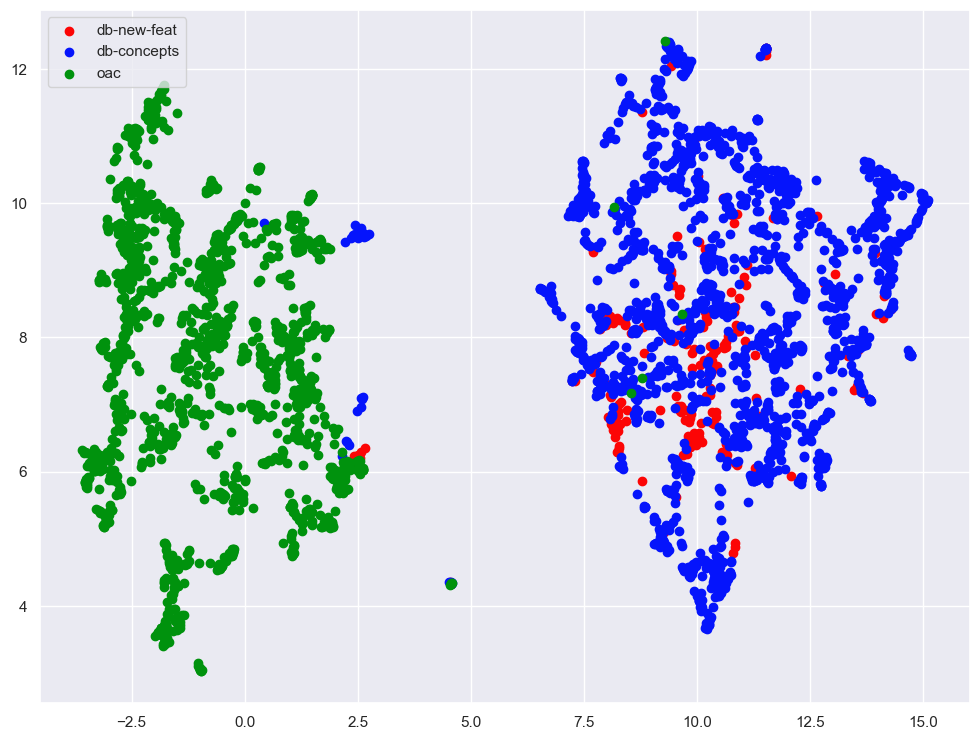

In [14]:
colors = ["#fc0505", "#0514fc", "#00920d"]

plt.figure(figsize=(12, 9))

# BOOK1, embeddings from the same book are contigous
plt.scatter(
    umap_embeds[:n_book1, 0],
    umap_embeds[:n_book1, 1],
    color=colors[0],
    label="db-new-feat",
)
# BOOK2
plt.scatter(
    umap_embeds[n_book1 : n_book1 + n_book2, 0],
    umap_embeds[n_book1 : n_book1 + n_book2, 1],
    color=colors[1],
    label="db-concepts",
)
# BOOK3
plt.scatter(
    umap_embeds[n_book1 + n_book2 :, 0],
    umap_embeds[n_book1 + n_book2 :, 1],
    color=colors[2],
    label="oac",
)

plt.legend(loc="upper left")
plt.show()